In [1]:
import math
import torch
import gpytorch
import matplotlib.pyplot as plt

# Gaussian Process Regression

## Introduction: the GP prior model

### Setting up a GP model with [GPytorch](https://gpytorch.ai/)

The next cell demonstrates the most critical features of a user-defined Gaussian process model in GPyTorch.

- In contrast to many existing GP packages, GPyTorch does not provide full GP models for the user.
- Rather, it provides *the tools necessary to quickly construct one*.
- This is because we believe, analogous to building a neural network in standard PyTorch, it is important to have the flexibility to include whatever components are necessary: this allows the user great flexibility in designing custom models.

For most GP regression models, you will need to construct the following GPyTorch objects:

1. A **GP Model** (`gpytorch.models.ExactGP`).
1. A **Mean** - This defines the prior mean of the GP.
    - (If you don't know which mean to use, a `gpytorch.means.ConstantMean()` is a good place to start.
1. A **Kernel** - This defines the prior covariance of the GP.
    - If you don't know which kernel to use, a `gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())` is a good place to start.
  
### The GP Model
  
The components of a user built (Exact) GP model in GPyTorch are, broadly speaking:

1. An `__init__` method that takes the data and a likelihood, and constructs whatever objects are necessary for the model's `forward` method. This will most commonly include things like a mean module and a kernel module.

2. A `forward` method that takes in some $n \times d$ data `x` and returns a `MultivariateNormal` with the *prior* mean and covariance evaluated at `x`.
    - It returns a **MultivariateNormal** Distribution (`gpytorch.distributions.MultivariateNormal`), the object used to represent multivariate normal distributions. 
    - In other words, it returns the vector $\mu(x)$ and the $n \times n$ matrix $K_{xx}$ representing the prior mean and covariance matrix of the GP.
    
This specification leaves a large amount of flexibility when defining a model. For example, to compose two kernels via addition, you can either add the kernel modules directly:

```python
self.covar_module = ScaleKernel(RBFKernel() + LinearKernel())
```

Or you can add the outputs of the kernel in the forward method:

```python
covar_x = self.rbf_kernel_module(x) + self.white_noise_module(x)
```

### Model modes

Like most PyTorch modules, the `ExactGP` has a `.train()` and `.eval()` mode.
- `.eval()` mode is for computing predictions through the model posterior.
- `.train()` mode is for optimizing model hyperameters.

In [2]:
# Exact GP model definition
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, x, y, mean_f, kernel_f, likelihood_f):
        super(ExactGPModel, self).__init__(x, y, likelihood_f)
        self.mean_module = mean_f
        self.covar_module = kernel_f
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

### Instantiations of the model

In [3]:
# Dummy data, to later be replaced with real data, now used for plotting the prior GP model
x = torch.linspace(-1, 1, 100)
y = torch.ones(100)

In [4]:
# Mean function
mean_f = gpytorch.means.ConstantMean()
# Kernel function
kernel_f = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

# Likelihood function
likelihood_f = gpytorch.likelihoods.GaussianLikelihood()

# GP model:
gp_model = ExactGPModel(
    x,
    y,
    mean_f,
    kernel_f,
    likelihood_f
)

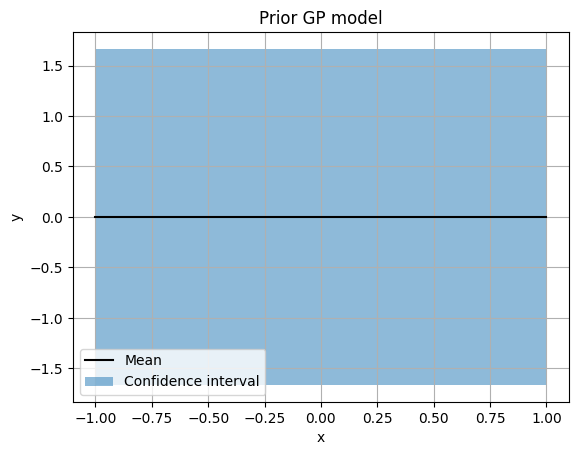

In [5]:
# Plotting the prior
with torch.no_grad():
    plt.figure()

    # The mean and covariance of the prior
    gp_model_prior = gp_model(x)

    # Plot the mean
    plt.plot(x.numpy(), gp_model_prior.mean.numpy(), 'k')
    # Plot the 95% confidence interval
    lower, upper = gp_model_prior.confidence_region()
    plt.fill_between(x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    plt.title('Prior GP model')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(['Mean', 'Confidence interval'])
    plt.grid()

<>:14: SyntaxWarning: invalid escape sequence '\s'
<>:14: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_256593/2780945832.py:14: SyntaxWarning: invalid escape sequence '\s'
  plt.legend(['Samples $f(x)\sim GP$'])
/home/iurteaga/miniconda3/envs/2025_stats_for_ai/lib/python3.13/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


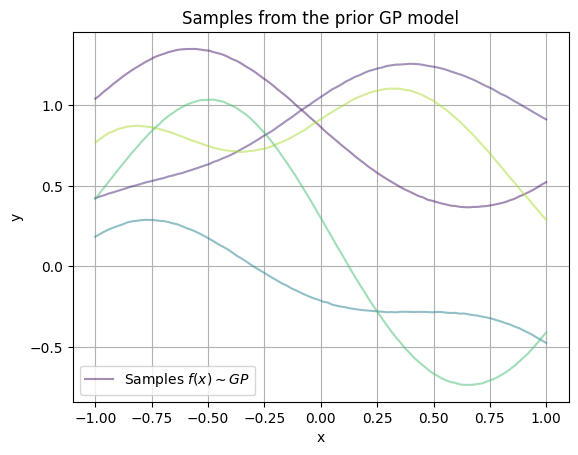

In [6]:
# Plot samples from the prior
with torch.no_grad():
    plt.figure()
    for _ in range(5):
        sample = gp_model_prior.sample()
        # Plot the samples, changing the color each sample
        # to make it easier to see the samples
        plt.plot(x.numpy(), sample.numpy(),
                 color=plt.cm.viridis(torch.rand(1).item()), alpha=0.5)
    plt.title('Samples from the prior GP model')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid()
    plt.legend(['Samples $f(x)\sim GP$'])
plt.show()

<>:20: SyntaxWarning: invalid escape sequence '\s'
<>:20: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_256593/4018962259.py:20: SyntaxWarning: invalid escape sequence '\s'
  plt.legend(['Samples $f(x)\sim GP$'])


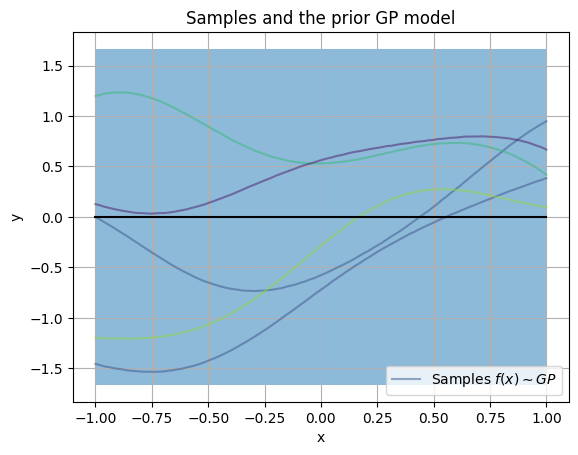

In [7]:
# Plot the prior GP model, along with some samples
# from the prior GP model
with torch.no_grad():
    plt.figure()
    for _ in range(5):
        sample = gp_model_prior.sample()
        # Plot the samples, changing the color each sample
        # to make it easier to see the samples
        plt.plot(x.numpy(), sample.numpy(),
                 color=plt.cm.viridis(torch.rand(1).item()), alpha=0.5)
    # Plot the mean
    plt.plot(x.numpy(), gp_model_prior.mean.numpy(), 'k')
    # Plot the 95% confidence interval
    lower, upper = gp_model_prior.confidence_region()
    plt.fill_between(x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    plt.title('Samples and the prior GP model')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid()
    plt.legend(['Samples $f(x)\sim GP$'])

# Replicate the above plot for different GP priors

Check out GPytorch documentation:

- [Different mean functions](https://docs.gpytorch.ai/en/stable/means.html)

- [Different kernel functions](https://docs.gpytorch.ai/en/stable/kernels.html)

In [8]:
# Mean functions
# Constant mean function
constant_mean_f = gpytorch.means.ConstantMean()
# Linear mean function with bias
linear_mean_f_bias = gpytorch.means.LinearMean(input_size=1, bias=True, )

mean_functions = [
    constant_mean_f,
    linear_mean_f_bias,
]

# Kernel function
rbf_kernel_f = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
mattern_kernel_f = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=2.5))
periodic_kernel_f = gpytorch.kernels.PeriodicKernel()
# Linear kernel
linear_kernel_f = gpytorch.kernels.LinearKernel()
# Polynomial kernel
polynomial_kernel_f = gpytorch.kernels.PolynomialKernel(degree=2, power=1)
# Cosine kernel
cosine_kernel_f = gpytorch.kernels.CosineKernel()

kernel_functions = [
    rbf_kernel_f,
    mattern_kernel_f,
    periodic_kernel_f,
    linear_kernel_f,
    polynomial_kernel_f,
    cosine_kernel_f
]

# Likelihood function
likelihood_f = gpytorch.likelihoods.GaussianLikelihood()

In [9]:
# GP models:

# Combine mean and kernel functions
mean_kernel_pairs = [
    (mean_f, kernel_f)
    for mean_f in mean_functions
    for kernel_f in kernel_functions
]
# Create a list of GP models
gp_models = []
for mean_f, kernel_f in mean_kernel_pairs:
    # Create a GP model with the given mean and kernel functions
    gp_model = ExactGPModel(
        x,
        y,
        mean_f,
        kernel_f,
        likelihood_f
    )
    gp_models.append(gp_model)

<>:24: SyntaxWarning: invalid escape sequence '\s'
<>:24: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_256593/1533197283.py:24: SyntaxWarning: invalid escape sequence '\s'
  plt.legend(['Samples $f(x)\sim GP$'])
/home/iurteaga/miniconda3/envs/2025_stats_for_ai/lib/python3.13/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/iurteaga/miniconda3/envs/2025_stats_for_ai/lib/python3.13/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


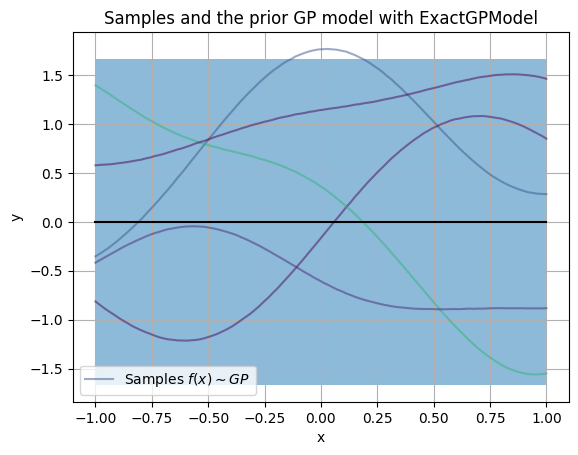

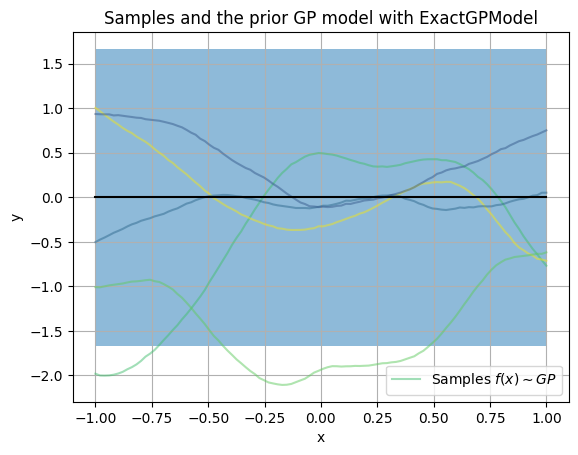

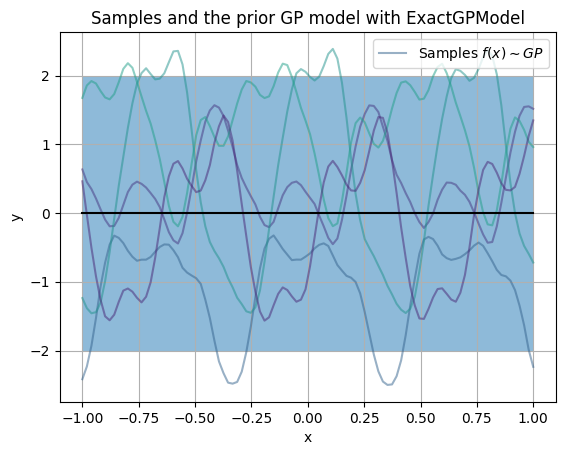

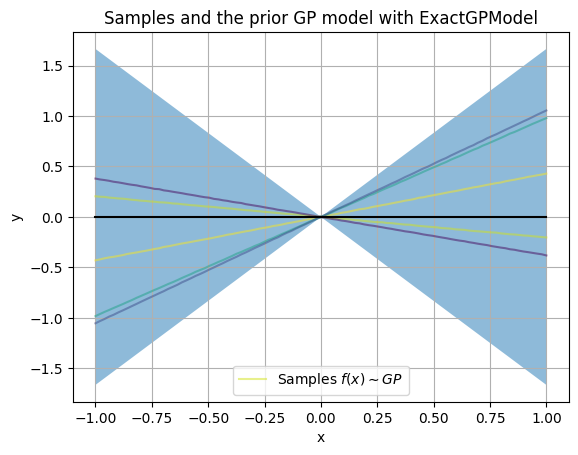

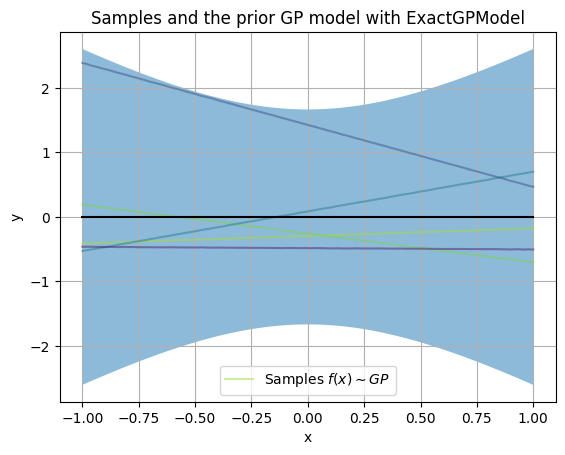

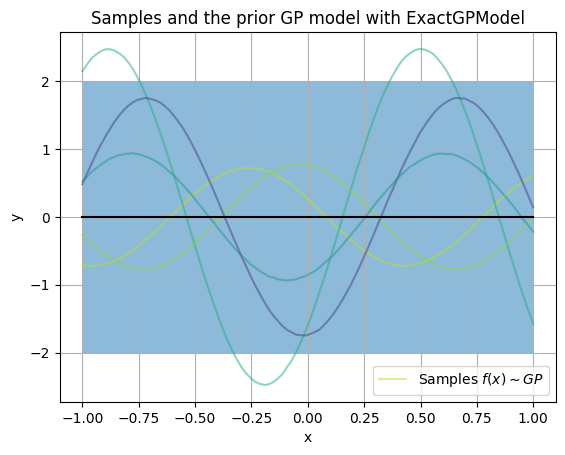

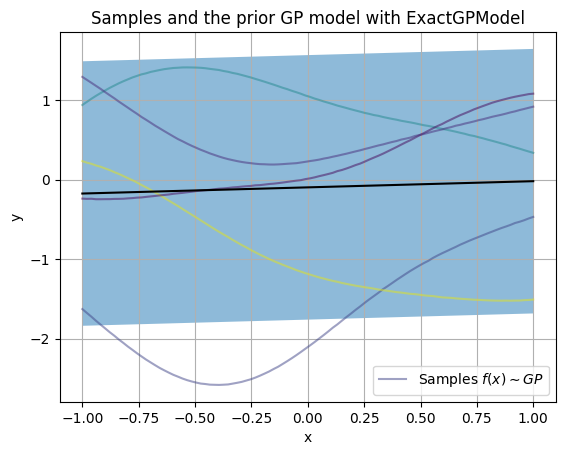

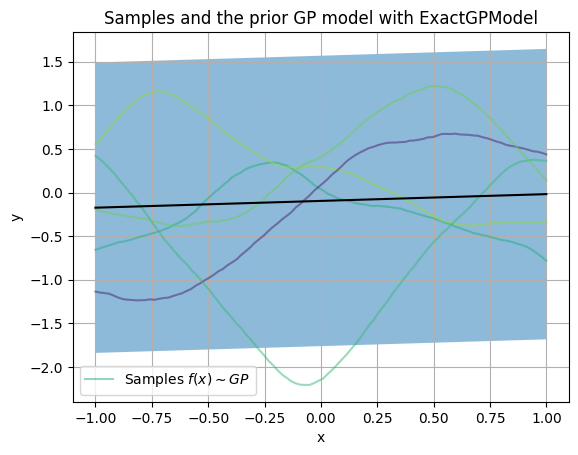

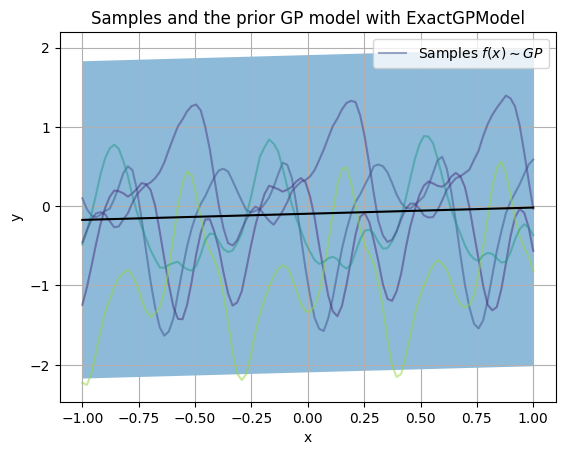

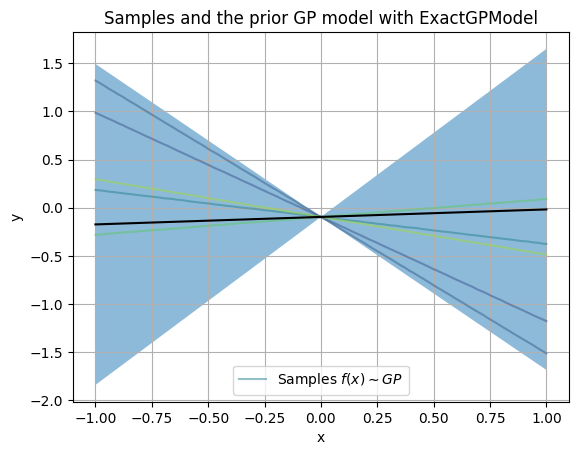

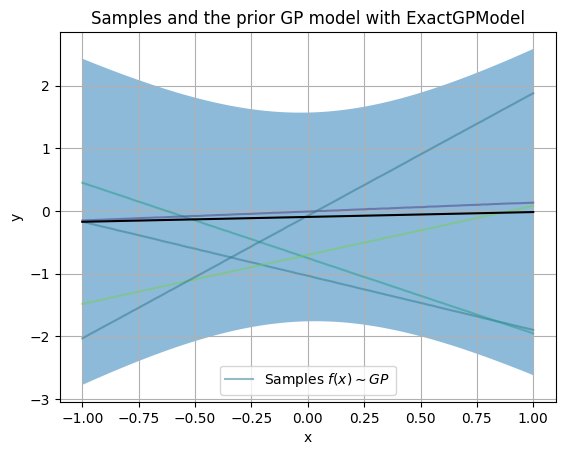

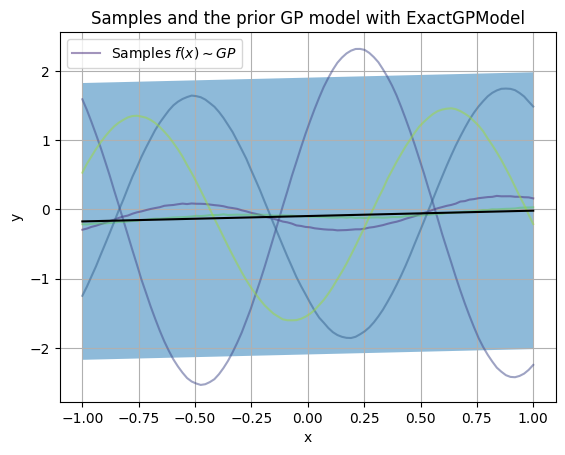

In [10]:
# Plot the prior GP model, along with some samples, from each prior GP model
for gp_model in gp_models:
    with torch.no_grad():
        # Instantiate the prior at x
        gp_model_prior = gp_model(x)

        # Plot the prior GP model
        plt.figure()
        for _ in range(5):
            sample = gp_model_prior.sample()
            # Plot the samples, changing the color each sample
            # to make it easier to see the samples
            plt.plot(x.numpy(), sample.numpy(),
                    color=plt.cm.viridis(torch.rand(1).item()), alpha=0.5)
        # Plot the mean
        plt.plot(x.numpy(), gp_model_prior.mean.numpy(), 'k')
        # Plot the 95% confidence interval
        lower, upper = gp_model_prior.confidence_region()
        plt.fill_between(x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
        plt.title('Samples and the prior GP model with %s' % gp_model.__class__.__name__)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.grid()
        plt.legend(['Samples $f(x)\sim GP$'])

## GP prior to posterior

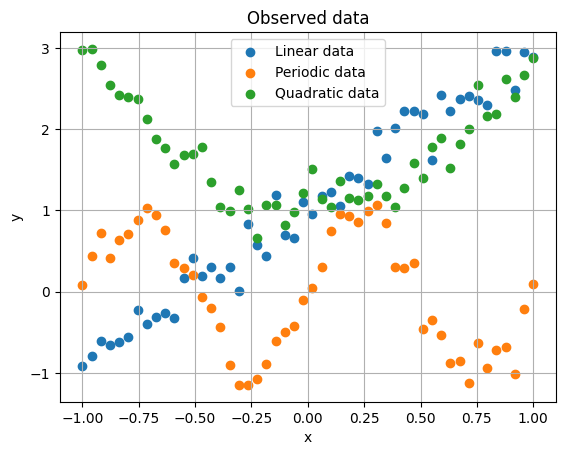

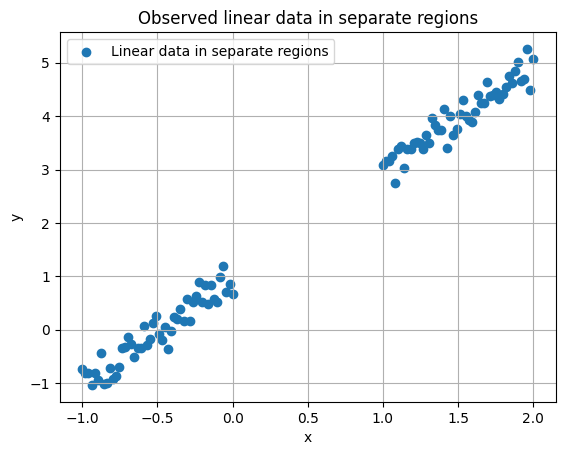

In [11]:
# Observe some data
x = torch.linspace(-1, 1, 50)
x_1 = torch.linspace(-1, 0, 50)
x_2 = torch.linspace(1, 2, 50)
x_1and2 = torch.cat((x_1, x_2), dim=0)
x_full = torch.linspace(-5, 5, 300)
# Observation noise
sigma = 0.1
sigma = 0.2
y_linear = 2 * x + 1 + torch.randn(x.size()) * sigma
y_linear_1and2 = 2 * x_1and2 + 1 + torch.randn(x_1and2.size()) * sigma
y_periodic = torch.sin(2 * math.pi * x) + torch.randn(x.size()) * sigma
y_quadratic = 2 * x ** 2 + 1 + torch.randn(x.size()) * sigma

# Plot the data
plt.figure()
plt.scatter(x.numpy(), y_linear.numpy(), label='Linear data')
plt.scatter(x.numpy(), y_periodic.numpy(), label='Periodic data')
plt.scatter(x.numpy(), y_quadratic.numpy(), label='Quadratic data')
plt.title('Observed data')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid()
plt.show()

# Plot the linear data in separate regions
plt.figure()
plt.scatter(x_1and2.numpy(), y_linear_1and2.numpy(), label='Linear data in separate regions')
plt.title('Observed linear data in separate regions')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid()
plt.show()

In [12]:
# Define a GP prior model

# Mean function
mean_f = gpytorch.means.ConstantMean()
# Kernel function
kernel_f = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

# Likelihood function
likelihood_f = gpytorch.likelihoods.GaussianLikelihood()



In [13]:
# GP model with observed data:
gp_model_linear = ExactGPModel(
    x,
    y_linear,
    mean_f,
    kernel_f,
    likelihood_f
)

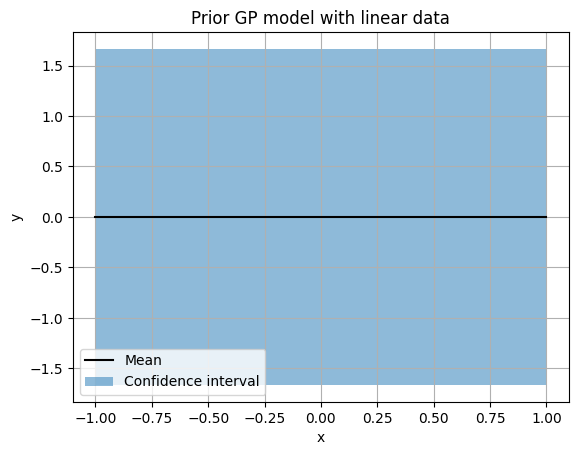

In [14]:
# Plot the prior GP model
with torch.no_grad():
    plt.figure()

    # The mean and covariance of the prior, over full x
    gp_model_prior = gp_model_linear(x)

    # Plot the mean
    plt.plot(x.numpy(), gp_model_prior.mean.numpy(), 'k')
    # Plot the 95% confidence interval
    lower, upper = gp_model_prior.confidence_region()
    plt.fill_between(x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    plt.title('Prior GP model with linear data')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(['Mean', 'Confidence interval'])
    plt.grid()


### Plot the posterior GP model

If we denote a test point (`test_x`) as `x*` with the true output being `y*`, then `model(test_x)` returns the model posterior distribution `p(f* | x*, X, y)`, for training data `X, y`.
    - This posterior is the distribution over the function we are trying to model, and thus quantifies our model uncertainty.

```python
f_preds = model(test_x)

f_mean = f_preds.mean
f_var = f_preds.variance
f_covar = f_preds.covariance_matrix
f_samples = f_preds.sample(sample_shape=torch.Size(1000,))
```

### Plot the posterior GP model along with some samples

<>:36: SyntaxWarning: invalid escape sequence '\s'
<>:36: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_256593/1966434983.py:36: SyntaxWarning: invalid escape sequence '\s'
  plt.legend(['Mean', 'Confidence interval', 'Samples $f(x)\sim GP$'])


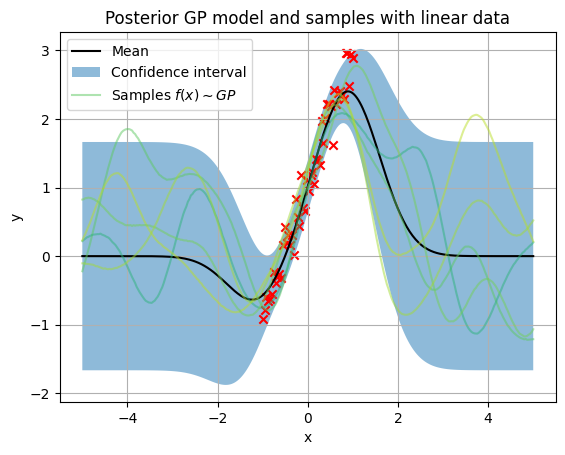

In [15]:
# GP model with observed data:
gp_model_linear = ExactGPModel(
    x,
    y_linear,
    mean_f,
    kernel_f,
    likelihood_f
)

# Set the model in evaluation mode
gp_model_linear.eval()

with torch.no_grad():
    plt.figure()

    # The mean and covariance of the posterior
    gp_model_posterior = gp_model_linear(x_full)

    # Plot the mean
    plt.plot(x_full.numpy(), gp_model_posterior.mean.numpy(), 'k')
    # Plot the 95% confidence interval
    lower, upper = gp_model_posterior.confidence_region()
    plt.fill_between(x_full.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    # Plot some samples from the posterior
    for _ in range(5):
        sample = gp_model_posterior.sample()
        # Plot the samples, changing the color each sample
        # to make it easier to see the samples
        plt.plot(x_full.numpy(), sample.numpy(),
                 color=plt.cm.viridis(torch.rand(1).item()), alpha=0.5)
    # Plot the observations
    plt.scatter(x.numpy(), y_linear.numpy(), color='red', marker='x')
    plt.title('Posterior GP model and samples with linear data')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(['Mean', 'Confidence interval', 'Samples $f(x)\sim GP$'])
    plt.grid()

<>:35: SyntaxWarning: invalid escape sequence '\s'
<>:35: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_256593/1809663053.py:35: SyntaxWarning: invalid escape sequence '\s'
  plt.legend(['Mean', 'Confidence interval', 'Samples $f(x)\sim GP$'])


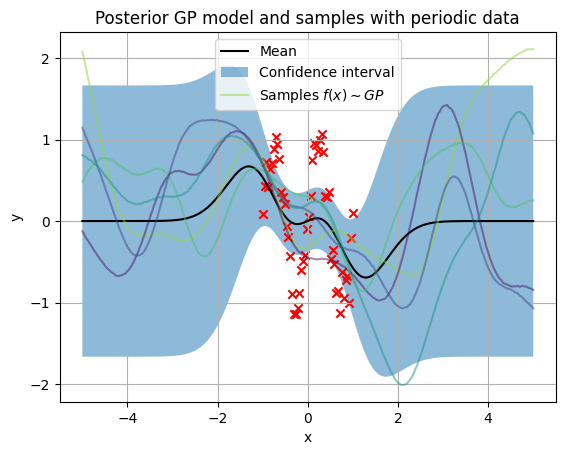

In [16]:
# Plot the posterior GP model with periodic data, along with some samples, from the posterior GP model
gp_model_periodic = ExactGPModel(
    x,
    y_periodic,
    mean_f,
    kernel_f,
    likelihood_f
)
# Set the model in evaluation mode
gp_model_periodic.eval()

with torch.no_grad():
    plt.figure()

    # The mean and covariance of the posterior
    gp_model_posterior = gp_model_periodic(x_full)

    # Plot the mean
    plt.plot(x_full.numpy(), gp_model_posterior.mean.numpy(), 'k')
    # Plot the 95% confidence interval
    lower, upper = gp_model_posterior.confidence_region()
    plt.fill_between(x_full.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    # Plot some samples from the posterior
    for _ in range(5):
        sample = gp_model_posterior.sample()
        # Plot the samples, changing the color each sample
        # to make it easier to see the samples
        plt.plot(x_full.numpy(), sample.numpy(),
                 color=plt.cm.viridis(torch.rand(1).item()), alpha=0.5)
    # Plot the observations
    plt.scatter(x.numpy(), y_periodic.numpy(), color='red', marker='x')
    plt.title('Posterior GP model and samples with periodic data')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(['Mean', 'Confidence interval', 'Samples $f(x)\sim GP$'])
    plt.grid()

<>:35: SyntaxWarning: invalid escape sequence '\s'
<>:35: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_256593/2795623970.py:35: SyntaxWarning: invalid escape sequence '\s'
  plt.legend(['Mean', 'Confidence interval', 'Samples $f(x)\sim GP$'])


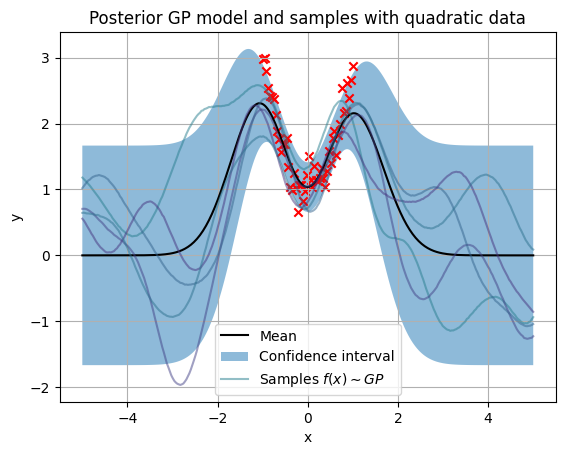

In [17]:
# Plot the posterior GP model with quadratic data, along with some samples, from the posterior GP model
gp_model_quadratic = ExactGPModel(
    x,
    y_quadratic,
    mean_f,
    kernel_f,
    likelihood_f
)
# Set the model in evaluation mode
gp_model_quadratic.eval()

with torch.no_grad():
    plt.figure()

    # The mean and covariance of the posterior
    gp_model_posterior = gp_model_quadratic(x_full)

    # Plot the mean
    plt.plot(x_full.numpy(), gp_model_posterior.mean.numpy(), 'k')
    # Plot the 95% confidence interval
    lower, upper = gp_model_posterior.confidence_region()
    plt.fill_between(x_full.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    # Plot some samples from the posterior
    for _ in range(5):
        sample = gp_model_posterior.sample()
        # Plot the samples, changing the color each sample
        # to make it easier to see the samples
        plt.plot(x_full.numpy(), sample.numpy(),
                 color=plt.cm.viridis(torch.rand(1).item()), alpha=0.5)
    # Plot the observations
    plt.scatter(x.numpy(), y_quadratic.numpy(), color='red', marker='x')
    plt.title('Posterior GP model and samples with quadratic data')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(['Mean', 'Confidence interval', 'Samples $f(x)\sim GP$'])
    plt.grid()
plt.show()


<>:36: SyntaxWarning: invalid escape sequence '\s'
<>:36: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_256593/1071873556.py:36: SyntaxWarning: invalid escape sequence '\s'
  plt.legend(['Mean', 'Confidence interval', 'Samples $f(x)\sim GP$'])


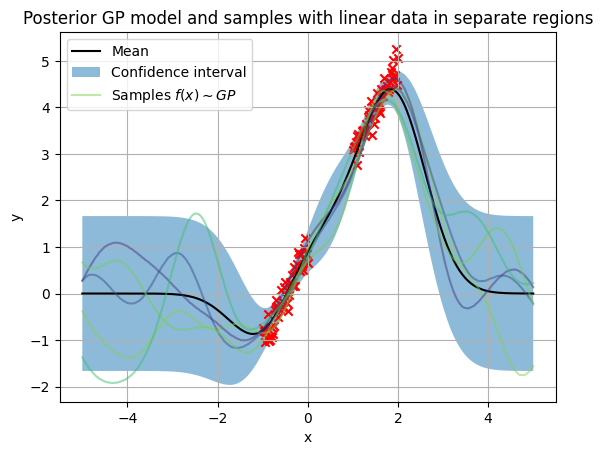

In [18]:
# Plot the posterior GP model with linear data in separate regions, along with some samples, from the posterior GP model
gp_model_linear_1and2 = ExactGPModel(
    x_1and2,
    y_linear_1and2,
    mean_f,
    kernel_f,
    likelihood_f
)

# Set the model in evaluation mode
gp_model_linear_1and2.eval()

with torch.no_grad():
    plt.figure()

    # The mean and covariance of the posterior
    gp_model_posterior = gp_model_linear_1and2(x_full)

    # Plot the mean
    plt.plot(x_full.numpy(), gp_model_posterior.mean.numpy(), 'k')
    # Plot the 95% confidence interval
    lower, upper = gp_model_posterior.confidence_region()
    plt.fill_between(x_full.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    # Plot some samples from the posterior
    for _ in range(5):
        sample = gp_model_posterior.sample()
        # Plot the samples, changing the color each sample
        # to make it easier to see the samples
        plt.plot(x_full.numpy(), sample.numpy(),
                 color=plt.cm.viridis(torch.rand(1).item()), alpha=0.5)
    # Plot the observations
    plt.scatter(x_1and2.numpy(), y_linear_1and2.numpy(), color='red', marker='x')
    plt.title('Posterior GP model and samples with linear data in separate regions')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(['Mean', 'Confidence interval', 'Samples $f(x)\sim GP$'])
    plt.grid()

<>:37: SyntaxWarning: invalid escape sequence '\s'
<>:37: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_256593/2268330885.py:37: SyntaxWarning: invalid escape sequence '\s'
  plt.legend(['Mean', 'Confidence interval', 'Samples $f(x)\sim GP$'])


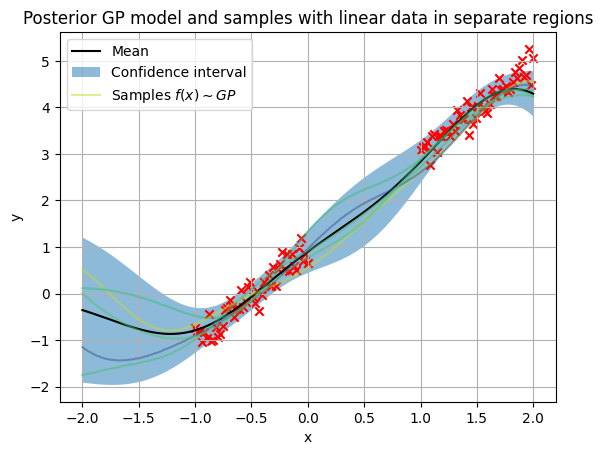

In [19]:
# Plot the posterior GP model with linear data in separate regions, along with some samples, from the posterior GP model
gp_model_linear_1and2 = ExactGPModel(
    x_1and2,
    y_linear_1and2,
    mean_f,
    kernel_f,
    likelihood_f
)

# Set the model in evaluation mode
gp_model_linear_1and2.eval()

with torch.no_grad():
    plt.figure()

    # The mean and covariance of the posterior, over region of interest
    x_interest = torch.linspace(-2, 2, 400)
    gp_model_posterior = gp_model_linear_1and2(x_interest)

    # Plot the mean
    plt.plot(x_interest.numpy(), gp_model_posterior.mean.numpy(), 'k')
    # Plot the 95% confidence interval
    lower, upper = gp_model_posterior.confidence_region()
    plt.fill_between(x_interest.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    # Plot some samples from the posterior
    for _ in range(5):
        sample = gp_model_posterior.sample()
        # Plot the samples, changing the color each sample
        # to make it easier to see the samples
        plt.plot(x_interest.numpy(), sample.numpy(),
                 color=plt.cm.viridis(torch.rand(1).item()), alpha=0.5)
    # Plot the observations
    plt.scatter(x_1and2.numpy(), y_linear_1and2.numpy(), color='red', marker='x')
    plt.title('Posterior GP model and samples with linear data in separate regions')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(['Mean', 'Confidence interval', 'Samples $f(x)\sim GP$'])
    plt.grid()

## Making predictions with the model

In the next cell, we make predictions with the model. To do this, we simply put the model and likelihood in eval mode, and call both modules on the test data.

If we denote a test point (`test_x`) as `x*` with the true output being `y*`, then `model(test_x)` returns the model posterior distribution `p(f* | x*, X, y)`, for training data `X, y`.
    - This posterior is the distribution over the function we are trying to model, and thus quantifies our model uncertainty.

In contrast, `likelihood(model(test_x))` gives us the posterior predictive distribution `p(y* | x*, X, y)` which is the probability distribution over the predicted output value.
    - By including the _likelihood noise_ which is the noise in your observation (e.g. due to noisy sensor), the prediction is over the observed value of the test point.

Thus, getting the predictive mean and variance, and then sampling functions from the GP at the given test points could be accomplished with calls like:


<>:43: SyntaxWarning: invalid escape sequence '\s'
<>:43: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_256593/691975423.py:43: SyntaxWarning: invalid escape sequence '\s'
  plt.legend(['Mean', 'Confidence interval', 'Samples $f(x)\sim GP$'])


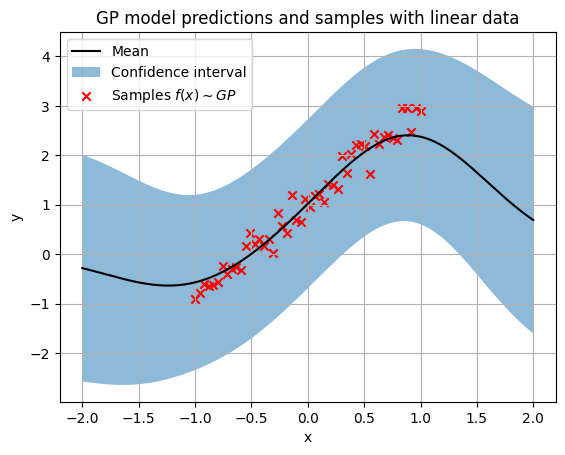

In [20]:
# Plot the predictions of the GP model with linear data, along with some samples, incorporating the likelihood
gp_model_linear = ExactGPModel(
    x,
    y_linear,
    mean_f,
    kernel_f,
    likelihood_f
)
# Set the model in evaluation mode
gp_model_linear.eval()
# Set the likelihood in evaluation mode
likelihood_f.eval()

# Whether to plot the samples or not
plot_samples = False
with torch.no_grad():
    plt.figure()

    # The mean and covariance of the predictions, over region of interest
    x_interest = torch.linspace(-2, 2, 400)
    gp_model_prediction = likelihood_f(gp_model_linear(x_interest))
    # Plot the mean
    plt.plot(x_interest.numpy(), gp_model_prediction.mean.numpy(), 'k')
    # Plot the 95% confidence interval
    lower, upper = gp_model_prediction.confidence_region()
    plt.fill_between(x_interest.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    if plot_samples:
        # Plot some samples from the posterior
        # Note that the samples are drawn from the likelihood, not the GP model
        # This is important, as it incorporates the noise in the observations
        # Plot some predicted samples
        for _ in range(5):
            sample = gp_model_prediction.sample()
            # Plot the samples, changing the color each sample
            # to make it easier to see the samples
            plt.plot(x_interest.numpy(), sample.numpy(),
                    color=plt.cm.viridis(torch.rand(1).item()), alpha=0.5)
    # Plot the observations
    plt.scatter(x.numpy(), y_linear.numpy(), color='red', marker='x')
    plt.title('GP model predictions and samples with linear data')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(['Mean', 'Confidence interval', 'Samples $f(x)\sim GP$'])
    plt.grid()
plt.show()

<>:42: SyntaxWarning: invalid escape sequence '\s'
<>:42: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_256593/1596403138.py:42: SyntaxWarning: invalid escape sequence '\s'
  plt.legend(['Mean', 'Confidence interval', 'Samples $f(x)\sim GP$'])


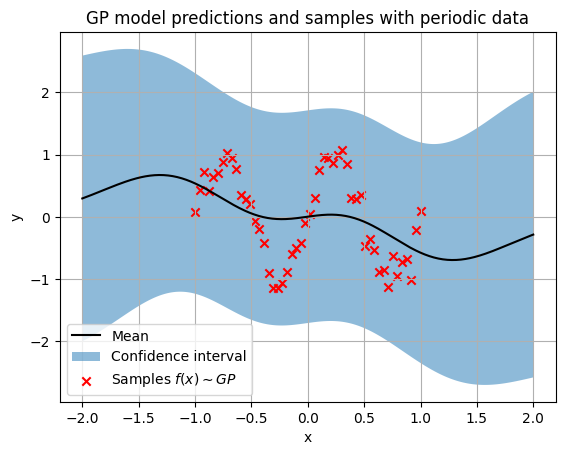

In [21]:
# Plot the predictions of the GP model with periodic data, along with some samples, incorporating the likelihood
gp_model_periodic = ExactGPModel(
    x,
    y_periodic,
    mean_f,
    kernel_f,
    likelihood_f
)
# Set the model in evaluation mode
gp_model_periodic.eval()
# Set the likelihood in evaluation mode
likelihood_f.eval()

plot_samples = False
with torch.no_grad():
    plt.figure()

    # The mean and covariance of the predictions, over region of interest
    x_interest = torch.linspace(-2, 2, 400)
    gp_model_prediction = likelihood_f(gp_model_periodic(x_interest))
    # Plot the mean
    plt.plot(x_interest.numpy(), gp_model_prediction.mean.numpy(), 'k')
    # Plot the 95% confidence interval
    lower, upper = gp_model_prediction.confidence_region()
    plt.fill_between(x_interest.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    if plot_samples:
        # Plot some samples from the posterior
        # Note that the samples are drawn from the likelihood, not the GP model
        # This is important, as it incorporates the noise in the observations
        # Plot some predicted samples
        for _ in range(5):
            sample = gp_model_prediction.sample()
            # Plot the samples, changing the color each sample
            # to make it easier to see the samples
            plt.plot(x_interest.numpy(), sample.numpy(),
                    color=plt.cm.viridis(torch.rand(1).item()), alpha=0.5)
    # Plot the observations
    plt.scatter(x.numpy(), y_periodic.numpy(), color='red', marker='x')
    plt.title('GP model predictions and samples with periodic data')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(['Mean', 'Confidence interval', 'Samples $f(x)\sim GP$'])
    plt.grid()
plt.show()

<>:41: SyntaxWarning: invalid escape sequence '\s'
<>:41: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_256593/536372742.py:41: SyntaxWarning: invalid escape sequence '\s'
  plt.legend(['Mean', 'Confidence interval', 'Samples $f(x)\sim GP$'])
/home/iurteaga/miniconda3/envs/2025_stats_for_ai/lib/python3.13/site-packages/gpytorch/models/exact_gp.py:296: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


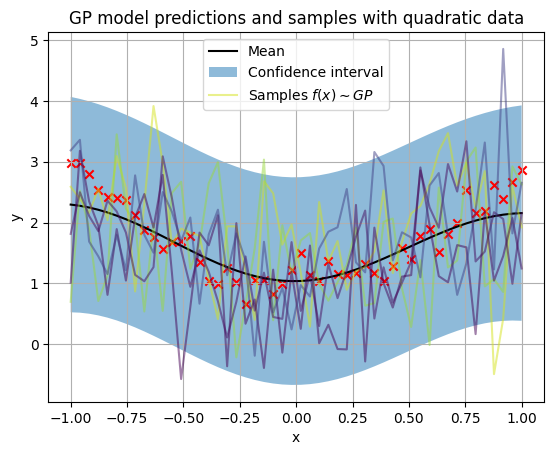

In [22]:
# Plot the predictions of the GP model with quadratic data, along with some samples, incorporating the likelihood
gp_model_quadratic = ExactGPModel(
    x,
    y_quadratic,
    mean_f,
    kernel_f,
    likelihood_f
)
# Set the model in evaluation mode
gp_model_quadratic.eval()
# Set the likelihood in evaluation mode
likelihood_f.eval()

plot_samples = True
with torch.no_grad():
    plt.figure()

    # The mean and covariance of the predictions
    gp_model_prediction = likelihood_f(gp_model_quadratic(x))
    # Plot the mean
    plt.plot(x.numpy(), gp_model_prediction.mean.numpy(), 'k')
    # Plot the 95% confidence interval
    lower, upper = gp_model_prediction.confidence_region()
    plt.fill_between(x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    if plot_samples:
        # Plot some samples from the posterior
        # Note that the samples are drawn from the likelihood, not the GP model
        # This is important, as it incorporates the noise in the observations
        # Plot some predicted samples
        for _ in range(5):
            sample = gp_model_prediction.sample()
            # Plot the samples, changing the color each sample
            # to make it easier to see the samples
            plt.plot(x.numpy(), sample.numpy(),
                    color=plt.cm.viridis(torch.rand(1).item()), alpha=0.5)
    # Plot the observations
    plt.scatter(x.numpy(), y_quadratic.numpy(), color='red', marker='x')
    plt.title('GP model predictions and samples with quadratic data')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(['Mean', 'Confidence interval', 'Samples $f(x)\sim GP$'])
    plt.grid()
plt.show()


## Training A GP model

In the next cell, we handle using Type-II MLE to train the hyperparameters of the Gaussian process.

In GPyTorch, we make use of the standard PyTorch optimizers as from `torch.optim`, and all trainable parameters of the model should be of type `torch.nn.Parameter`.
    - Because GP models directly extend `torch.nn.Module`, calls to methods like `model.parameters()` or `model.named_parameters()` function as you might expect coming from PyTorch.

In most cases, the boilerplate code below will work well. It has the same basic components as the standard PyTorch training loop:

1. Zero all parameter gradients
2. Call the model and compute the loss
3. Call backward on the loss to fill in gradients
4. Take a step on the optimizer

However, defining custom training loops allows for greater flexibility.
    - For example, it is easy to save the parameters at each step of training, or use different learning rates for different parameters .

### Training the GP model

In [23]:
def train_gp_model(model, likelihood, train_x, train_y, training_iter=50):
    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1) 

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model) # Includes GaussianLikelihood parameters

    # Iterate in training
    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.covar_module.base_kernel.lengthscale.item(),
            model.likelihood.noise.item()
        ))
        optimizer.step()

    # Return the model and the likelihood
    return model, likelihood

In [24]:
# Define a GP prior
gp_model_linear = ExactGPModel(
    x,
    y_linear,
    mean_f,
    kernel_f,
    likelihood_f
)

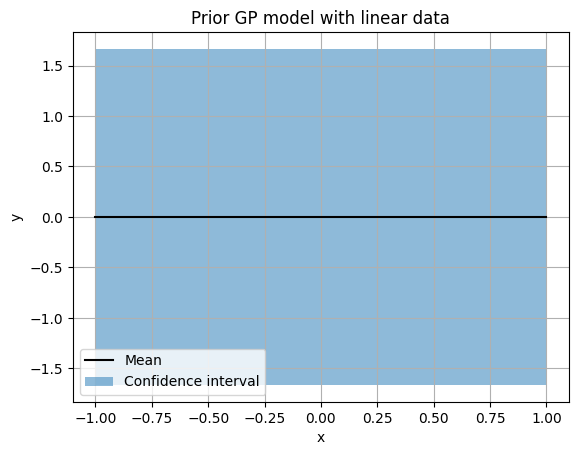

In [25]:
# Plot the prior GP model
with torch.no_grad():
    plt.figure()

    # The mean and covariance of the prior
    gp_model_prior = gp_model_linear(x)

    # Plot the mean
    plt.plot(x.numpy(), gp_model_prior.mean.numpy(), 'k')
    # Plot the 95% confidence interval
    lower, upper = gp_model_prior.confidence_region()
    plt.fill_between(x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    plt.title('Prior GP model with linear data')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(['Mean', 'Confidence interval'])
    plt.grid()

<>:27: SyntaxWarning: invalid escape sequence '\s'
<>:27: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_256593/579083923.py:27: SyntaxWarning: invalid escape sequence '\s'
  plt.legend(['Mean', 'Confidence interval', 'Samples $f(x)\sim GP$'])


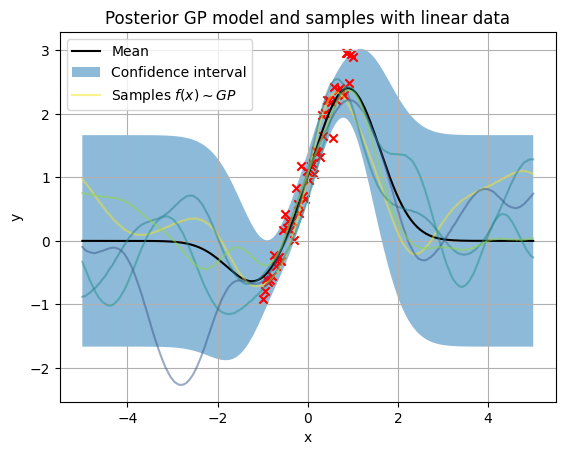

In [26]:
# Plot the posterior GP model with linear data
gp_model_linear.eval()
likelihood_f.eval()
with torch.no_grad():
    plt.figure()

    # The mean and covariance of the posterior
    gp_model_posterior = gp_model_linear(x_full)

    # Plot the mean
    plt.plot(x_full.numpy(), gp_model_posterior.mean.numpy(), 'k')
    # Plot the 95% confidence interval
    lower, upper = gp_model_posterior.confidence_region()
    plt.fill_between(x_full.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    # Plot some samples from the posterior
    for _ in range(5):
        sample = gp_model_posterior.sample()
        # Plot the samples, changing the color each sample
        # to make it easier to see the samples
        plt.plot(x_full.numpy(), sample.numpy(),
                 color=plt.cm.viridis(torch.rand(1).item()), alpha=0.5)
    # Plot the observations
    plt.scatter(x.numpy(), y_linear.numpy(), color='red', marker='x')
    plt.title('Posterior GP model and samples with linear data')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(['Mean', 'Confidence interval', 'Samples $f(x)\sim GP$'])
    plt.grid()
plt.show()  

In [27]:
# Set the model and likelihood in training mode
gp_model_linear.train()
likelihood_f.train()

# Train the GP model
gp_model_linear_trained, likelihood_f_trained = train_gp_model(
    gp_model_linear,
    likelihood_f,
    x,
    y_linear,
    training_iter=50
)

Iter 1/50 - Loss: 0.956   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 0.914   lengthscale: 0.744   noise: 0.644
Iter 3/50 - Loss: 0.874   lengthscale: 0.798   noise: 0.598
Iter 4/50 - Loss: 0.834   lengthscale: 0.852   noise: 0.554
Iter 5/50 - Loss: 0.796   lengthscale: 0.907   noise: 0.513
Iter 6/50 - Loss: 0.758   lengthscale: 0.961   noise: 0.474
Iter 7/50 - Loss: 0.721   lengthscale: 1.014   noise: 0.437
Iter 8/50 - Loss: 0.684   lengthscale: 1.064   noise: 0.403
Iter 9/50 - Loss: 0.648   lengthscale: 1.110   noise: 0.370
Iter 10/50 - Loss: 0.611   lengthscale: 1.150   noise: 0.340
Iter 11/50 - Loss: 0.576   lengthscale: 1.185   noise: 0.312
Iter 12/50 - Loss: 0.540   lengthscale: 1.215   noise: 0.286
Iter 13/50 - Loss: 0.504   lengthscale: 1.240   noise: 0.262
Iter 14/50 - Loss: 0.470   lengthscale: 1.261   noise: 0.240
Iter 15/50 - Loss: 0.435   lengthscale: 1.280   noise: 0.219
Iter 16/50 - Loss: 0.401   lengthscale: 1.298   noise: 0.200
Iter 17/50 - Loss: 0.368   length

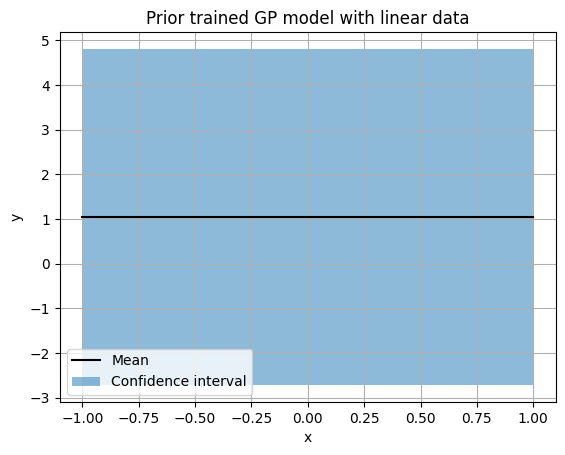

In [28]:
# Plot the prior, trained GP model
with torch.no_grad():
    plt.figure()

    # The mean and covariance of the prior
    gp_model_prior = gp_model_linear_trained(x)

    # Plot the mean
    plt.plot(x.numpy(), gp_model_prior.mean.numpy(), 'k')
    # Plot the 95% confidence interval
    lower, upper = gp_model_prior.confidence_region()
    plt.fill_between(x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    plt.title('Prior trained GP model with linear data')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(['Mean', 'Confidence interval'])
    plt.grid()
plt.show()

<>:28: SyntaxWarning: invalid escape sequence '\s'
<>:28: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_256593/3466891402.py:28: SyntaxWarning: invalid escape sequence '\s'
  plt.legend(['Mean', 'Confidence interval', 'Samples $f(x)\sim GP$'])


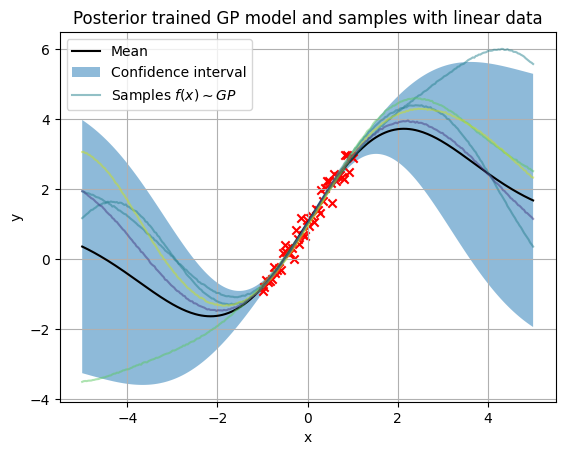

In [29]:
# Plot the posterior, trained GP model with linear data
gp_model_linear_trained.eval()
likelihood_f_trained.eval()

with torch.no_grad():
    plt.figure()

    # The mean and covariance of the posterior
    gp_model_posterior = gp_model_linear_trained(x_full)

    # Plot the mean
    plt.plot(x_full.numpy(), gp_model_posterior.mean.numpy(), 'k')
    # Plot the 95% confidence interval
    lower, upper = gp_model_posterior.confidence_region()
    plt.fill_between(x_full.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    # Plot some samples from the posterior
    for _ in range(5):
        sample = gp_model_posterior.sample()
        # Plot the samples, changing the color each sample
        # to make it easier to see the samples
        plt.plot(x_full.numpy(), sample.numpy(),
                 color=plt.cm.viridis(torch.rand(1).item()), alpha=0.5)
    # Plot the observations
    plt.scatter(x.numpy(), y_linear.numpy(), color='red', marker='x')
    plt.title('Posterior trained GP model and samples with linear data')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(['Mean', 'Confidence interval', 'Samples $f(x)\sim GP$'])
    plt.grid()
plt.show()

<>:27: SyntaxWarning: invalid escape sequence '\s'
<>:27: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_256593/138406913.py:27: SyntaxWarning: invalid escape sequence '\s'
  plt.legend(['Mean', 'Confidence interval', 'Samples $f(x)\sim GP$'])


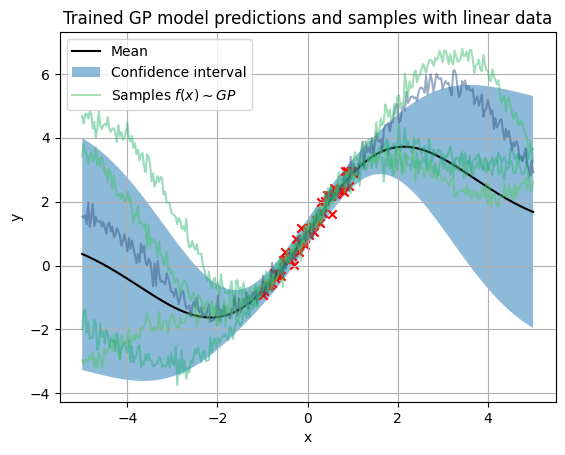

In [30]:
# Plot the predictions of the trained GP model with linear data: i.e., incorporate the likelihood
gp_model_linear_trained.eval()
likelihood_f_trained.eval()

with torch.no_grad():
    plt.figure()

    # The mean and covariance of the predictions
    gp_model_prediction = likelihood_f_trained(gp_model_linear_trained(x_full))
    # Plot the mean
    plt.plot(x_full.numpy(), gp_model_prediction.mean.numpy(), 'k')
    # Plot the 95% confidence interval
    lower, upper = gp_model_prediction.confidence_region()
    plt.fill_between(x_full.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    # Plot some predicted samples
    for _ in range(5):
        sample = gp_model_prediction.sample()
        # Plot the samples, changing the color each sample
        # to make it easier to see the samples
        plt.plot(x_full.numpy(), sample.numpy(),
                 color=plt.cm.viridis(torch.rand(1).item()), alpha=0.5)
    # Plot the observations
    plt.scatter(x.numpy(), y_linear.numpy(), color='red', marker='x')
    plt.title('Trained GP model predictions and samples with linear data')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(['Mean', 'Confidence interval', 'Samples $f(x)\sim GP$'])
    plt.grid()
plt.show()

In [31]:
# Define a GP prior, with linear data in separate regions
gp_model_linear_1and2 = ExactGPModel(
    x_1and2,
    y_linear_1and2,
    mean_f,
    kernel_f,
    likelihood_f
)

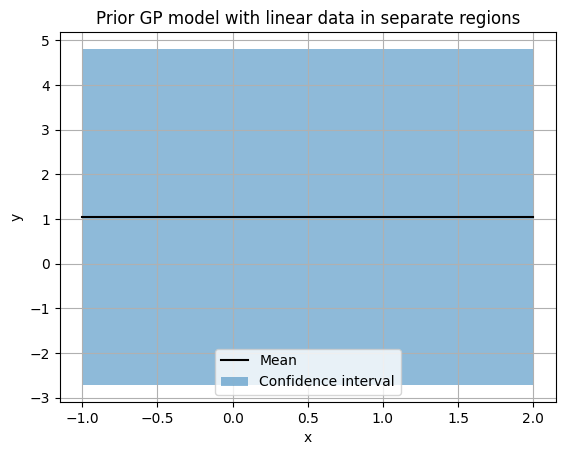

In [32]:
# Plot the prior GP model
with torch.no_grad():
    plt.figure()

    # The mean and covariance of the prior
    gp_model_prior = gp_model_linear_1and2(x_1and2)

    # Plot the mean
    plt.plot(x_1and2.numpy(), gp_model_prior.mean.numpy(), 'k')
    # Plot the 95% confidence interval
    lower, upper = gp_model_prior.confidence_region()
    plt.fill_between(x_1and2.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    plt.title('Prior GP model with linear data in separate regions')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(['Mean', 'Confidence interval'])
    plt.grid()
plt.show()

<>:30: SyntaxWarning: invalid escape sequence '\s'
<>:30: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_256593/1312265359.py:30: SyntaxWarning: invalid escape sequence '\s'
  plt.legend(['Mean', 'Confidence interval', 'Samples $f(x)\sim GP$'])


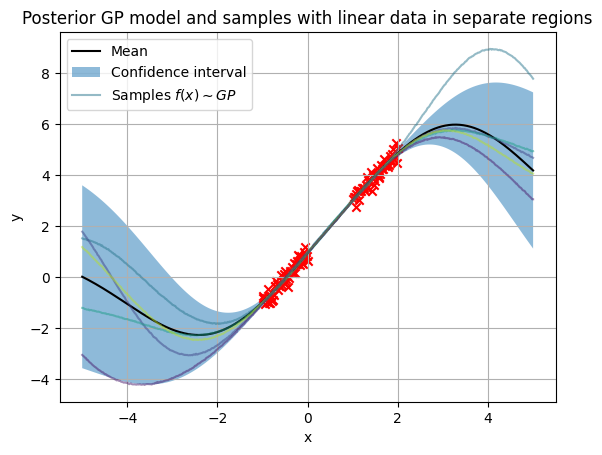

In [33]:
# Plot the posterior GP model with linear data in separate regions
gp_model_linear_1and2.eval()
likelihood_f.eval()

with torch.no_grad():
    plt.figure()

    # The mean and covariance of the posterior, over region of interest
    x_interest = torch.linspace(-5, 5, 500)
    #x_interest = torch.linspace(-2, 3, 400)
    gp_model_posterior = gp_model_linear_1and2(x_interest)

    # Plot the mean
    plt.plot(x_interest.numpy(), gp_model_posterior.mean.numpy(), 'k')
    # Plot the 95% confidence interval
    lower, upper = gp_model_posterior.confidence_region()
    plt.fill_between(x_interest.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    # Plot some samples from the posterior
    for _ in range(5):
        sample = gp_model_posterior.sample()
        # Plot the samples, changing the color each sample
        # to make it easier to see the samples
        plt.plot(x_interest.numpy(), sample.numpy(),
                 color=plt.cm.viridis(torch.rand(1).item()), alpha=0.5)
    # Plot the observations
    plt.scatter(x_1and2.numpy(), y_linear_1and2.numpy(), color='red', marker='x')
    plt.title('Posterior GP model and samples with linear data in separate regions')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(['Mean', 'Confidence interval', 'Samples $f(x)\sim GP$'])
    plt.grid()

In [34]:
# Train the GP model
gp_model_linear_1and2.train()
likelihood_f.train()
gp_model_linear_1and2_trained, likelihood_f_trained = train_gp_model(
    gp_model_linear_1and2,
    likelihood_f,
    x_1and2,
    y_linear_1and2,
    training_iter=50
)

Iter 1/50 - Loss: -0.020   lengthscale: 1.996   noise: 0.041
Iter 2/50 - Loss: -0.021   lengthscale: 1.910   noise: 0.045
Iter 3/50 - Loss: -0.023   lengthscale: 1.829   noise: 0.043
Iter 4/50 - Loss: -0.025   lengthscale: 1.756   noise: 0.041
Iter 5/50 - Loss: -0.025   lengthscale: 1.708   noise: 0.040
Iter 6/50 - Loss: -0.026   lengthscale: 1.697   noise: 0.040
Iter 7/50 - Loss: -0.027   lengthscale: 1.714   noise: 0.041
Iter 8/50 - Loss: -0.028   lengthscale: 1.748   noise: 0.042
Iter 9/50 - Loss: -0.028   lengthscale: 1.791   noise: 0.043
Iter 10/50 - Loss: -0.029   lengthscale: 1.839   noise: 0.043
Iter 11/50 - Loss: -0.029   lengthscale: 1.889   noise: 0.043
Iter 12/50 - Loss: -0.030   lengthscale: 1.940   noise: 0.042
Iter 13/50 - Loss: -0.030   lengthscale: 1.990   noise: 0.041
Iter 14/50 - Loss: -0.031   lengthscale: 2.038   noise: 0.041
Iter 15/50 - Loss: -0.031   lengthscale: 2.085   noise: 0.041
Iter 16/50 - Loss: -0.032   lengthscale: 2.131   noise: 0.041
Iter 17/50 - Loss

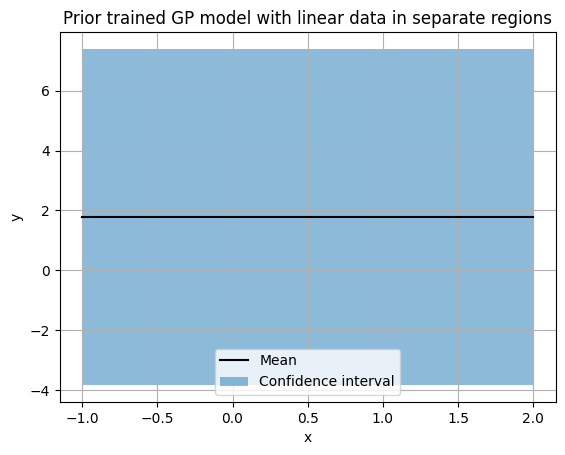

In [35]:
# Plot the prior, trained GP model
with torch.no_grad():
    plt.figure()

    # The mean and covariance of the prior
    gp_model_prior = gp_model_linear_1and2_trained(x_1and2)

    # Plot the mean
    plt.plot(x_1and2.numpy(), gp_model_prior.mean.numpy(), 'k')
    # Plot the 95% confidence interval
    lower, upper = gp_model_prior.confidence_region()
    plt.fill_between(x_1and2.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    plt.title('Prior trained GP model with linear data in separate regions')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(['Mean', 'Confidence interval'])
    plt.grid()

<>:29: SyntaxWarning: invalid escape sequence '\s'
<>:29: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_256593/2647374843.py:29: SyntaxWarning: invalid escape sequence '\s'
  plt.legend(['Mean', 'Confidence interval', 'Samples $f(x)\sim GP$'])
/home/iurteaga/miniconda3/envs/2025_stats_for_ai/lib/python3.13/site-packages/linear_operator/operators/_linear_operator.py:2163: NumericalWarning: Runtime Error when computing Cholesky decomposition: Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.. Using symeig method.
  warnings.warn(


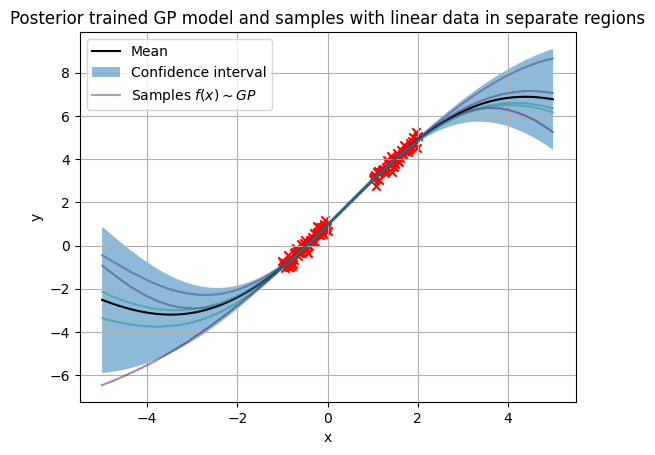

In [36]:
# Plot the posterior, trained GP model with linear data in separate regions
gp_model_linear_1and2_trained.eval()
likelihood_f_trained.eval()

with torch.no_grad():
    plt.figure()

    # The mean and covariance of the posterior, over region of interest
    x_interest = torch.linspace(-2, 3, 400)
    x_interest = torch.linspace(-5, 5, 500)
    gp_model_posterior = gp_model_linear_1and2_trained(x_interest)
    # Plot the mean
    plt.plot(x_interest.numpy(), gp_model_posterior.mean.numpy(), 'k')
    # Plot the 95% confidence interval
    lower, upper = gp_model_posterior.confidence_region()
    plt.fill_between(x_interest.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    # Plot some samples from the posterior
    for _ in range(5):
        sample = gp_model_posterior.sample()
        # Plot the samples, changing the color each sample
        # to make it easier to see the samples
        plt.plot(x_interest.numpy(), sample.numpy(),
                 color=plt.cm.viridis(torch.rand(1).item()), alpha=0.5)
    # Plot the observations
    plt.scatter(x_1and2.numpy(), y_linear_1and2.numpy(), color='red', marker='x')
    plt.title('Posterior trained GP model and samples with linear data in separate regions')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(['Mean', 'Confidence interval', 'Samples $f(x)\sim GP$'])
    plt.grid()
plt.show()

<>:28: SyntaxWarning: invalid escape sequence '\s'
<>:28: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_256593/4089834416.py:28: SyntaxWarning: invalid escape sequence '\s'
  plt.legend(['Mean', 'Confidence interval', 'Samples $f(x)\sim GP$'])


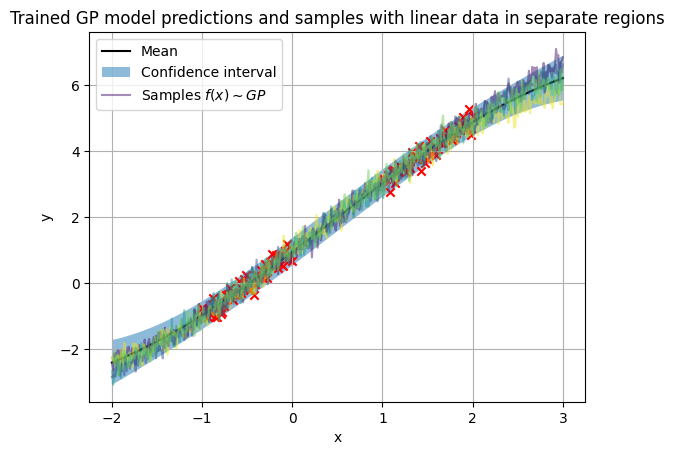

In [37]:
# Plot the predictions of the trained GP model with linear data in separate regions: i.e., incorporate the likelihood
gp_model_linear_1and2_trained.eval()
likelihood_f_trained.eval()

with torch.no_grad():
    plt.figure()

    # The mean and covariance of the predictions, over region of interest
    x_interest = torch.linspace(-2, 3, 400)
    gp_model_prediction = likelihood_f_trained(gp_model_linear_1and2_trained(x_interest))
    # Plot the mean
    plt.plot(x_interest.numpy(), gp_model_prediction.mean.numpy(), 'k')
    # Plot the 95% confidence interval
    lower, upper = gp_model_prediction.confidence_region()
    plt.fill_between(x_interest.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    # Plot some predicted samples
    for _ in range(5):
        sample = gp_model_prediction.sample()
        # Plot the samples, changing the color each sample
        # to make it easier to see the samples
        plt.plot(x_interest.numpy(), sample.numpy(),
                 color=plt.cm.viridis(torch.rand(1).item()), alpha=0.5)
    # Plot the observations
    plt.scatter(x_1and2.numpy(), y_linear_1and2.numpy(), color='red', marker='x')
    plt.title('Trained GP model predictions and samples with linear data in separate regions')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(['Mean', 'Confidence interval', 'Samples $f(x)\sim GP$'])
    plt.grid()